In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Data Imports
avl = pd.read_csv('GMU_2021_Summer_AVL.csv')
cad = pd.read_csv('GMU_2021_Summer_CAD.csv')

## Assign AVL column values
avl.columns = ['AVL_IncidentNumber',
               'AVL_UnitID',
               'AVL_Timestamp',
               'AVL_UnitStatus',
               'AVL_Speed']
avl.dropna(subset = ['AVL_IncidentNumber'],
           inplace = True)
avl.reset_index(inplace = True, drop = True)

## Merge AVL and CAD datasets
# I think doing an outer join is probably better cause then we can figure out what incidents do not have a
# corresponding record between datasets
df = avl.merge(cad, 
               how = 'outer', 
               left_on = ['AVL_IncidentNumber',
                          'AVL_UnitID',
                          'AVL_UnitStatus'],
               right_on = ['CAD_IncidentNumber',
                           'CAD_UnitID',
                           'CAD_UnitStatus'],
               suffixes = ('_avl', '_cad'))

# ### Inner Join Info ###
# <class 'pandas.core.frame.DataFrame'>
# Int64Index: 21696754 entries, 0 to 21696753
# Data columns (total 9 columns):
#  #   Column              Dtype 
# ---  ------              ----- 
#  0   AVL_IncidentNumber  object
#  1   AVL_UnitID          object
#  2   AVL_Timestamp       object
#  3   AVL_UnitStatus      object
#  4   AVL_Speed           object
#  5   CAD_IncidentNumber  object
#  6   CAD_UnitID          object
#  7   CAD_Timestamp       object
#  8   CAD_UnitStatus      object
# dtypes: object(9)
# memory usage: 1.6+ GB

# ### Nulls ###
# AVL_IncidentNumber    0
# AVL_UnitID            0
# AVL_Timestamp         0
# AVL_UnitStatus        0
# AVL_Speed             0
# CAD_IncidentNumber    0
# CAD_UnitID            0
# CAD_Timestamp         0
# CAD_UnitStatus        0
# dtype: int64


# ---------------------------------------------------------------------------------------------
### Outer Join Info ###
### Info ###
# <class 'pandas.core.frame.DataFrame'>
# Int64Index: 24321445 entries, 0 to 24321444
# Data columns (total 9 columns):
#  #   Column              Dtype 
# ---  ------              ----- 
#  0   AVL_IncidentNumber  object
#  1   AVL_UnitID          object
#  2   AVL_Timestamp       object
#  3   AVL_UnitStatus      object
#  4   AVL_Speed           object
#  5   CAD_IncidentNumber  object
#  6   CAD_UnitID          object
#  7   CAD_Timestamp       object
#  8   CAD_UnitStatus      object
# dtypes: object(9)
# memory usage: 1.8+ GB

#### Nulls ####
# AVL_IncidentNumber    2624424
# AVL_UnitID            2624424
# AVL_Timestamp         2624424
# AVL_UnitStatus        2624424
# AVL_Speed             2624424
# CAD_IncidentNumber        267
# CAD_UnitID                267
# CAD_Timestamp             267
# CAD_UnitStatus            267

# convert object to timestamp proper
df['AVL_Timestamp'] = df['AVL_Timestamp'].str.replace('ED', '')
df['CAD_Timestamp'] = df['CAD_Timestamp'].str.replace('ED', '')
df['AVL_Timestamp'] = df['AVL_Timestamp'].str.replace('ES', '')
df['CAD_Timestamp'] = df['CAD_Timestamp'].str.replace('ES', '')

# convert timestamp data to DateTime format
df['AVL_Timestamp'] = pd.to_datetime(df['AVL_Timestamp'], format = '%Y%m%d%H%M%S')
df['CAD_Timestamp'] = pd.to_datetime(df['CAD_Timestamp'], format = '%Y%m%d%H%M%S')

# create delta col
df['CAD_AVL_Timestamp_DELTA'] = abs(df['AVL_Timestamp'] - df['CAD_Timestamp'])

# moving and not moving statuses
moving_statuses = ['ER','TR']
not_moving = ['AM','AQ','OS','OT','TA','WP']

# create Status Speed Match
df['Status_Speed_Match'] = np.where((df['AVL_Speed'].isin(['Moving', 'moving']) & df['CAD_UnitStatus'].isin(['ER'])), True, False)

# create a subset of data that only has Cad status = er
er = df[df['CAD_UnitStatus'].isin(['ER'])]
er[er['Status_Speed_Match'] == False]

# what percentage of ER status are not moving?
len(er[er['Status_Speed_Match'] == False]) / len(er) * 100

14.258763735786609

Unit Prefixes: 
- A – ambulance 
- E – engine 
- M – medic 
- R – rescue squad 
- T/TT/TL – truck/tiller/tower 
Unit Status: 
- AK – acknowledge 
- AM – available on mobile (cell phone) - AQ – available in quarters (station) - AR – available on radio 
- DP – dispatched 
- ER – enroute 
- OS – on-scene 
- OT – out of service 
- TA – transport arrived (at medical facility) - TR – transport (begins) 
- WP – with patient 
Response Times: 
Unit Suffixes: 
- B – supplemental 
- C – supplemental 
- E – supplemental (usually volunteer, no  career firefighters) 

- eastern daylight = ED (end of timestamp)
- Turnout: Unit dispatch to enroute 

## Analysis ideas

- CHRIS: create a timestamp delta col, plot the distribution of the deltas
- CHRIS: create thresholds? maybe? of timestamps - 1 min delta, 5 min, etc.
- find delta in first instance of status to first instance of next status, compare to cad, check if deltas in each dataset are close
    - define turnout (standby to dispatch/ dispatch to en route only?)
    - calculating turnout: 
    - maybe create another column for incident start time
    - sort data by composite key + timestamp
- CAROLYN: get turnaround: query by incident id, start stop time, and status
- OSCAR AND JESS: given cad unit status = en route, does moving col = moving?
- UNASSIGNED: pick out incident samples and plot timestamps just to find examples, see if its doing what we think its doing
    - incident and unit and see side by side of the cad and avl data, see if behaving predictably (dispatch time detlas, en route deltas, etc. )

- Distribution plots:
    - Overall timestamps differences in the composite key join datetime columns
    - For a given incident number, how much time is spent with status == ER AND speed == not moving 

In [2]:
df.head()

,AVL_IncidentNumber,AVL_UnitID,AVL_Timestamp,AVL_UnitStatus,AVL_Speed,CAD_IncidentNumber,CAD_UnitID,CAD_Timestamp,CAD_UnitStatus,CAD_AVL_Timestamp_DELTA,Status_Speed_Match
0,E192700962,E423,2019-09-27 09:45:46,WP,moving,E192700962,E423,2019-09-27 09:37:11,WP,0 days 00:08:35,False
1,E192700962,E423,2019-09-27 09:45:46,WP,moving,E192700962,E423,2019-09-27 09:36:51,WP,0 days 00:08:55,False
2,E192700962,E423,2019-09-27 09:47:52,WP,moving,E192700962,E423,2019-09-27 09:37:11,WP,0 days 00:10:41,False
3,E192700962,E423,2019-09-27 09:47:52,WP,moving,E192700962,E423,2019-09-27 09:36:51,WP,0 days 00:11:01,False
4,E192701000,R401,2019-09-27 09:45:46,ER,moving,E192701000,R401,2019-09-27 09:41:59,ER,0 days 00:03:47,True


In [3]:
df['CAD_AVL_Timestamp_DELTA'].describe()

count                     21696754
mean     0 days 00:16:50.965599370
std      0 days 03:38:50.298041371
min                0 days 00:00:00
25%                0 days 00:02:13
50%                0 days 00:04:30
75%                0 days 00:09:56
max               11 days 18:46:17
Name: CAD_AVL_Timestamp_DELTA, dtype: object

In [4]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(20, 14))

<Figure size 1440x1008 with 0 Axes>

<Figure size 1440x1008 with 0 Axes>

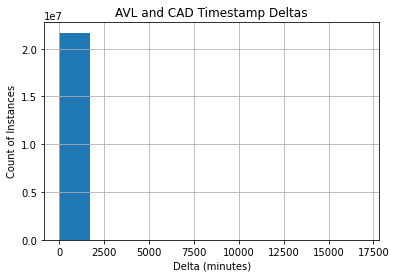

In [7]:
(df['CAD_AVL_Timestamp_DELTA'] / pd.Timedelta(minutes=1)).hist()
deltas = (df['CAD_AVL_Timestamp_DELTA'] / pd.Timedelta(minutes=1))
plt.title('AVL and CAD Timestamp Deltas')
plt.xlabel('Delta (minutes)')
plt.ylabel('Count of Instances');

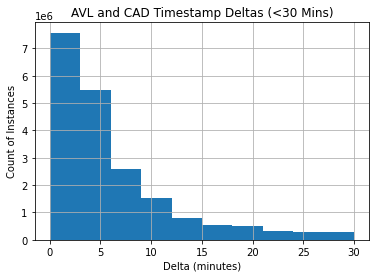

In [8]:
(df[df['CAD_AVL_Timestamp_DELTA'] < df['CAD_AVL_Timestamp_DELTA'].max()/565]['CAD_AVL_Timestamp_DELTA'] / pd.Timedelta(minutes=1)).hist()
plt.title('AVL and CAD Timestamp Deltas (<30 Mins)')
plt.xlabel('Delta (minutes)')
plt.ylabel('Count of Instances');

In [ ]:
df['CAD_AVL_Timestamp_DELTA'].max()/565

In [ ]:
# '0 days 00:00:00'